
## Trial to combine middle ear and bruxism tagging to identify pure moments of middle ear activation

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

In [2]:
import numpy as np
import mne
from tinnsleep.reports import combine_brux_MEMA, generate_bruxism_report, generate_MEMA_report
from tinnsleep.data import CreateRaw, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list
from tinnsleep.utils import merge_labels_list
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tinnsleep.config import Config
import scipy
print("Config loaded")


Config loaded


## Loading parameters and results

In [7]:


# change to --overwrite True if you want to force to recompute the results
#%run ../compute_results.py --bruxism True --mema True --overwrite False 

#mema_files= pd.read_csv("data/mema_files.csv",engine='python', sep=", ")["files_with_mema"].values

results_MEMA = pd.read_pickle("data/reports_and_datas_MEMA.pk").to_dict()
results_brux = pd.read_pickle("data/reports_and_datas_bruxism.pk").to_dict()
min_burst_joining_brux = 3 
min_burst_joining_MEMA = 0
EDF_list = Config.bruxisme_files
print(EDF_list)
print(results_brux.keys())
print(results_MEMA.keys())

['F:/Acou_sommeil/EDF_renom\\1AC26_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1BA07_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1BA07_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1CB23_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1CC05_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1CC05_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1DA15_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1DA15_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1DL12_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1DL12_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1DM32_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1GB18_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1GB18_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1GF14_cohort2.edf', 'F:/Acou_sommeil/EDF_renom\\1GF14_nuit_hab.edf', 'F:/Acou_sommeil/EDF_renom\\1GF14_nuit_son.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_1.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_1_resmed.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_2.edf', 'F:/Acou_sommeil/EDF_renom\\1HB20_nuit_2_resmed.edf', 'F:/Acou_sommeil/

## Bruxism + MEMA processing for pure MEMA visualisation

Files processed : 
1AC26_cohort2.edf 0.992
139032
4266
{'Clean data duration': 23530.736, 'Total burst duration': 1057.968, 'Total number of burst': 1605, 'Number of bursts per hour': 245.55118037956822, 'bruxism episode NREM count': 149, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 149, 'Number of bursts per episode': 10.771812080536913, 'Number of episodes per hour': 22.79571705704403, 'Number of tonic episodes per hour': 3.9777761307593607, 'Number of phasic episodes per hour': 3.225058493707974, 'Number of mixed episodes per hour': 1.4417908560106238, 'Mean duration of tonic episode': 6.133230769230977, 'Mean duration of phasic episode': 5.161317647058861, 'Mean duration of mixed episode': 18.560842105263298, 'End count': 28, 'End ratio': 0.00020139248518326715, 'NREM count': 97135, 'NREM ratio': 0.6986521088670234, 'Wake count': 41780, 'Wake ratio': 0.3005063582484608, 'start count': 89, 'start ratio': 0.0006401403993325277, 'Power Ratio': array([12.31758499])}
1

heu
135120
4256
5725
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
41
Nb épisodes bruxisme purs : 
98
nb episodes MEMA combinés : 
52
Nb épisodes MEMA purs : 
92
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
4.4046868733169084
Nb épisodes bruxisme purs : 
10.528275941098952
nb episodes MEMA combinés : 
5.586432132011689
Nb épisodes MEMA purs : 
9.883687618174527
0.992
135120
6884
{'Clean data duration': 21547.976, 'Total burst duration': 1707.232, 'Total number of burst': 1740, 'Number of bursts per hour': 290.70015671077414, 'bruxism episode NREM count': 138, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 138, 'Number of bursts per episode': 12.608695652173912, 'Number of episodes per hour': 23.055529670164848, 'Number of tonic episodes per hour': 1.5036215002281421, 'Number of phasic episodes per hour': 4.350478207326758, 'Number of mixed episodes per hour': 0.9943950188175448, 'Mean duration of tonic episode': 61.8897777777774

Interpolating non proportional list, expecting to have non-uniform shift across recording


1.0
98080
3894
{'Clean data duration': 20337.75, 'Total burst duration': 973.5, 'Total number of burst': 823, 'Number of bursts per hour': 145.67983183980527, 'bruxism episode NREM count': 107, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 107, 'Number of bursts per episode': 7.691588785046729, 'Number of episodes per hour': 18.940148246487443, 'Number of tonic episodes per hour': 7.080429251023343, 'Number of phasic episodes per hour': 1.5930965814802522, 'Number of mixed episodes per hour': 1.3718331673857727, 'Mean duration of tonic episode': 4.81875, 'Mean duration of phasic episode': 5.3125, 'Mean duration of mixed episode': 26.274193548387096, 'End count': 72, 'End ratio': 0.000734094616639478, 'NREM count': 81888, 'NREM ratio': 0.834910277324633, 'Wake count': 16080, 'Wake ratio': 0.1639477977161501, 'start count': 40, 'start ratio': 0.0004078303425774878, 'Power Ratio': array([14.99369241])}
167640
0.25


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
98080
8
4820
0.25
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
1
Nb épisodes bruxisme purs : 
107
nb episodes MEMA combinés : 
1
Nb épisodes MEMA purs : 
87
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
0.1468189233278956
Nb épisodes bruxisme purs : 
15.70962479608483
nb episodes MEMA combinés : 
0.1468189233278956
Nb épisodes MEMA purs : 
12.773246329526918
1HB20_nuit_1_resmed.edf (does not have both bruxism and mema)... skipping
1HB20_nuit_2.edf 1.0
100320
6362
{'Clean data duration': 23956.75, 'Total burst duration': 1590.5, 'Total number of burst': 1108, 'Number of bursts per hour': 166.50004695962517, 'Total number of episodes': 118, 'Number of bursts per episode': 9.389830508474576, 'Number of episodes per hour': 17.73195445959907, 'Number of tonic episodes per hour': 5.860561219697997, 'Number of phasic episodes per hour': 1.8032496060609222, 'Number of mixed episodes per hour': 1.1645987039143457, 'Mean duration of tonic episode': 8.65384

Interpolating non proportional list, expecting to have non-uniform shift across recording


1.0
100320
6362
{'Clean data duration': 23956.75, 'Total burst duration': 1590.5, 'Total number of burst': 1108, 'Number of bursts per hour': 166.50004695962517, 'Total number of episodes': 118, 'Number of bursts per episode': 9.389830508474576, 'Number of episodes per hour': 17.73195445959907, 'Number of tonic episodes per hour': 5.860561219697997, 'Number of phasic episodes per hour': 1.8032496060609222, 'Number of mixed episodes per hour': 1.1645987039143457, 'Mean duration of tonic episode': 8.653846153846153, 'Mean duration of phasic episode': 5.8125, 'Mean duration of mixed episode': 41.733870967741936, 'Power Ratio': array([19.43540849, 17.59843678])}
115280
0.25


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
100320
4655
2986
0.25
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
17
Nb épisodes bruxisme purs : 
101
nb episodes MEMA combinés : 
40
Nb épisodes MEMA purs : 
190
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
2.4401913875598087
Nb épisodes bruxisme purs : 
14.497607655502392
nb episodes MEMA combinés : 
5.741626794258373
Nb épisodes MEMA purs : 
27.272727272727273
1HB20_nuit_2_resmed.edf (does not have both bruxism and mema)... skipping
1HB20_nuit_3.edf (does not have both bruxism and mema)... skipping
1HS25_cohort2.edf 0.992
173264
5260
{'Clean data duration': 22669.184, 'Total burst duration': 1304.48, 'Total number of burst': 1397, 'Number of bursts per hour': 221.85183198477722, 'bruxism episode NREM count': 110, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 110, 'Number of bursts per episode': 12.7, 'Number of episodes per hour': 17.468648187777735, 'Number of tonic episodes per hour': 1.429253033545451, 'Number of phasic e

heu
217176
3515
5721
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
25
Nb épisodes bruxisme purs : 
61
nb episodes MEMA combinés : 
28
Nb épisodes MEMA purs : 
67
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
1.6710098068223542
Nb épisodes bruxisme purs : 
4.077263928646544
nb episodes MEMA combinés : 
1.8715309836410368
Nb épisodes MEMA purs : 
4.478306282283909
0.992
217176
7295
{'Clean data duration': 19462.048, 'Total burst duration': 1809.16, 'Total number of burst': 1136, 'Number of bursts per hour': 210.1320477680458, 'bruxism episode NREM count': 86, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 86, 'Number of bursts per episode': 13.209302325581396, 'Number of episodes per hour': 15.907883897933045, 'Number of tonic episodes per hour': 2.2197047299441457, 'Number of phasic episodes per hour': 2.5230643763698457, 'Number of mixed episodes per hour': 0.8716040572914013, 'Mean duration of tonic episode': 49.39333333333267, 

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
102580
1000
{'Clean data duration': 23257.44, 'Total burst duration': 248.0, 'Total number of burst': 302, 'Number of bursts per hour': 46.74633149650177, 'bruxism episode NREM count': 42, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 42, 'Number of bursts per episode': 7.190476190476191, 'Number of episodes per hour': 6.501145439910842, 'Number of tonic episodes per hour': 3.0957835428146865, 'Number of phasic episodes per hour': 0.5374280230326296, 'Number of mixed episodes per hour': 0.30710172744721687, 'Mean duration of tonic episode': 4.253199999999896, 'Mean duration of phasic episode': 6.075999999999632, 'Mean duration of mixed episode': 6.726999999999748, 'NREM count': 100281, 'NREM ratio': 0.9775882238253071, 'Wake count': 2274, 'Wake ratio': 0.022168063950087736, 'start count': 25, 'start ratio': 0.0002437122246051862, 'Power Ratio': array([94.2244824 , 96.19805384])}
111732
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
102580
83
924
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
3
Nb épisodes bruxisme purs : 
42
nb episodes MEMA combinés : 
3
Nb épisodes MEMA purs : 
111
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
0.42453097189290495
Nb épisodes bruxisme purs : 
5.94343360650067
nb episodes MEMA combinés : 
0.42453097189290495
Nb épisodes MEMA purs : 
15.707645960037484
1SL21_nuit_2_resmed.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_3.edf 0.992
145440
7115
{'Clean data duration': 32450.8, 'Total burst duration': 1764.52, 'Total number of burst': 864, 'Number of bursts per hour': 95.84971711020992, 'Total number of episodes': 208, 'Number of bursts per episode': 4.153846153846154, 'Number of episodes per hour': 23.074931896902388, 'Number of tonic episodes per hour': 13.201523537170116, 'Number of phasic episodes per hour': 1.0454719144058082, 'Number of mixed episodes per hour': 1.403133358807795, 'Mean duration of tonic episode': 7.7

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
145440
7115
{'Clean data duration': 32450.8, 'Total burst duration': 1764.52, 'Total number of burst': 864, 'Number of bursts per hour': 95.84971711020992, 'Total number of episodes': 208, 'Number of bursts per episode': 4.153846153846154, 'Number of episodes per hour': 23.074931896902388, 'Number of tonic episodes per hour': 13.201523537170116, 'Number of phasic episodes per hour': 1.0454719144058082, 'Number of mixed episodes per hour': 1.403133358807795, 'Mean duration of tonic episode': 7.760941176470496, 'Mean duration of phasic episode': 4.705473684210519, 'Mean duration of mixed episode': 13.455215686274391, 'Power Ratio': array([163.85149789,  91.5153819 ])}
139152
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
145440
644
6739
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
16
Nb épisodes bruxisme purs : 
194
nb episodes MEMA combinés : 
17
Nb épisodes MEMA purs : 
210
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
1.5969338869370806
Nb épisodes bruxisme purs : 
19.3628233791121
nb episodes MEMA combinés : 
1.6967422548706481
Nb épisodes MEMA purs : 
20.959757266049184
1SL21_nuit_3_resmed.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_4.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_5.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_6.edf 1.0
141520
10341
{'Clean data duration': 29687.25, 'Total burst duration': 2585.25, 'Total number of burst': 280, 'Number of bursts per hour': 33.95397013869591, 'Total number of episodes': 54, 'Number of bursts per episode': 5.185185185185185, 'Number of episodes per hour': 6.548265669605639, 'Number of tonic episodes per hour': 4.608038804537301, 'Number of phasic

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
187376
5323
{'Clean data duration': 24838.936, 'Total burst duration': 1320.104, 'Total number of burst': 1615, 'Number of bursts per hour': 234.0679971154964, 'bruxism episode NREM count': 216, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 216, 'Number of bursts per episode': 7.476851851851852, 'Number of episodes per hour': 31.305688778295494, 'Number of tonic episodes per hour': 5.652416029414464, 'Number of phasic episodes per hour': 4.0256796828978505, 'Number of mixed episodes per hour': 2.336331958824645, 'Mean duration of tonic episode': 3.459282051282431, 'Mean duration of phasic episode': 5.170357142857321, 'Mean duration of mixed episode': 9.90855384615419, 'End count': 33, 'End ratio': 0.00017611647169327982, 'NREM count': 100403, 'NREM ratio': 0.5358370335581931, 'Wake count': 86855, 'Wake ratio': 0.46353321663393393, 'start count': 85, 'start ratio': 0.00045363333617966017, 'Power Ratio': array([26.84406224, 21.04751817])}
186532
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
187376
1566
4332
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
47
Nb épisodes bruxisme purs : 
184
nb episodes MEMA combinés : 
47
Nb épisodes MEMA purs : 
490
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
3.641117669905052
Nb épisodes bruxisme purs : 
14.254588324734671
nb episodes MEMA combinés : 
3.641117669905052
Nb épisodes MEMA purs : 
37.960588473478204
1UC22_nuit_1_resmed.edf (does not have both bruxism and mema)... skipping
1UC22_nuit_2.edf 0.992
121732
9174
{'Clean data duration': 29304.92, 'Total burst duration': 2275.152, 'Total number of burst': 2607, 'Number of bursts per hour': 320.2602156907441, 'Total number of episodes': 335, 'Number of bursts per episode': 7.782089552238806, 'Number of episodes per hour': 41.15349913939366, 'Number of tonic episodes per hour': 7.493622231352279, 'Number of phasic episodes per hour': 5.087800956289933, 'Number of mixed episodes per hour': 3.259848516904329, 'Mean duration of tonic episode':

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
121732
9174
{'Clean data duration': 29304.92, 'Total burst duration': 2275.152, 'Total number of burst': 2607, 'Number of bursts per hour': 320.2602156907441, 'Total number of episodes': 335, 'Number of bursts per episode': 7.782089552238806, 'Number of episodes per hour': 41.15349913939366, 'Number of tonic episodes per hour': 7.493622231352279, 'Number of phasic episodes per hour': 5.087800956289933, 'Number of mixed episodes per hour': 3.259848516904329, 'Mean duration of tonic episode': 3.9273442622951804, 'Mean duration of phasic episode': 7.396934131736526, 'Mean duration of mixed episode': 14.917084112149654, 'Power Ratio': array([25.10533898, 28.583478  ])}
134472
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
121732
3608
9217
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
66
Nb épisodes bruxisme purs : 
273
nb episodes MEMA combinés : 
73
Nb épisodes MEMA purs : 
389
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
7.870276641548912
Nb épisodes bruxisme purs : 
32.55432610822505
nb episodes MEMA combinés : 
8.70500295201622
Nb épisodes MEMA purs : 
46.38693353882616
1UC22_nuit_2_resmed.edf (does not have both bruxism and mema)... skipping
1UC22_nuit_3.edf (does not have both bruxism and mema)... skipping
1ZN04_cohort2.edf 0.992
130684
4221
{'Clean data duration': 25495.392, 'Total burst duration': 1046.808, 'Total number of burst': 1339, 'Number of bursts per hour': 189.06946008125703, 'bruxism episode NREM count': 154, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 154, 'Number of bursts per episode': 8.694805194805195, 'Number of episodes per hour': 21.745105939143826, 'Number of tonic episodes per hour': 1.5532218527959876, 'Number

heu
93668
8206
2199
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
71
Nb épisodes bruxisme purs : 
48
nb episodes MEMA combinés : 
86
Nb épisodes MEMA purs : 
105
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
11.003172495306002
Nb épisodes bruxisme purs : 
7.438764503868846
nb episodes MEMA combinés : 
13.327786402765016
Nb épisodes MEMA purs : 
16.2722973522131
2LS05_nuit_1.edf 0.992
102016
3810
{'Clean data duration': 23252.232, 'Total burst duration': 944.88, 'Total number of burst': 827, 'Number of bursts per hour': 128.0393211283975, 'bruxism episode NREM count': 69, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 69, 'Number of bursts per episode': 11.985507246376812, 'Number of episodes per hour': 10.682845414582136, 'Number of tonic episodes per hour': 3.096476931762938, 'Number of phasic episodes per hour': 1.5358525581544171, 'Number of mixed episodes per hour': 0.3455668255847439, 'Mean duration of tonic episode': 16.715

heu
155480
5379
4904
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
120
Nb épisodes bruxisme purs : 
141
nb episodes MEMA combinés : 
132
Nb épisodes MEMA purs : 
74
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
11.203598429836426
Nb épisodes bruxisme purs : 
13.1642281550578
nb episodes MEMA combinés : 
12.32395827282007
Nb épisodes MEMA purs : 
6.908885698399129
3CL02_cohort2.edf 0.992
203384
3778
{'Clean data duration': 10909.768, 'Total burst duration': 936.944, 'Total number of burst': 366, 'Number of bursts per hour': 120.77250405324843, 'bruxism episode NREM count': 34, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 34, 'Number of bursts per episode': 10.764705882352942, 'Number of episodes per hour': 11.219303655219798, 'Number of tonic episodes per hour': 1.9798771156270234, 'Number of phasic episodes per hour': 0.9820190493510036, 'Number of mixed episodes per hour': 1.3093587324680047, 'Mean duration of tonic episode': 

heu
185160
2013
5040
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
33
Nb épisodes bruxisme purs : 
107
nb episodes MEMA combinés : 
37
Nb épisodes MEMA purs : 
67
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
2.5871260426901928
Nb épisodes bruxisme purs : 
8.388560199025777
nb episodes MEMA combinés : 
2.900717078167792
Nb épisodes MEMA purs : 
5.2526498442497855
0.992
185160
4593
{'Clean data duration': 24470.656, 'Total burst duration': 1139.064, 'Total number of burst': 1503, 'Number of bursts per hour': 221.11381076175482, 'bruxism episode NREM count': 140, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 140, 'Number of bursts per episode': 10.735714285714286, 'Number of episodes per hour': 20.59609681080883, 'Number of tonic episodes per hour': 3.2365294988413877, 'Number of phasic episodes per hour': 3.2836062915518083, 'Number of mixed episodes per hour': 1.0215664018161181, 'Mean duration of tonic episode': 5.0840000000007

C:\Users\Zeta\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Zeta\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


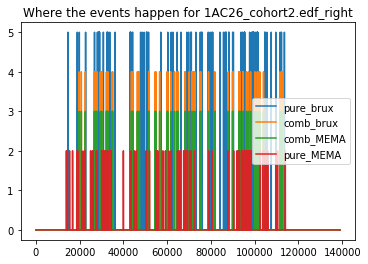

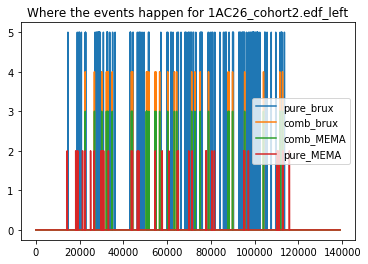

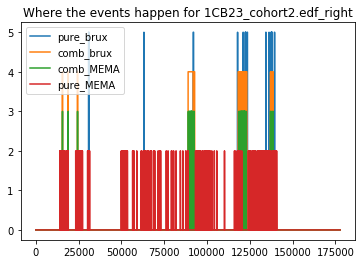

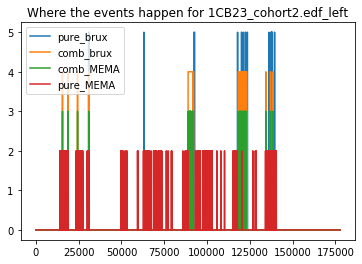

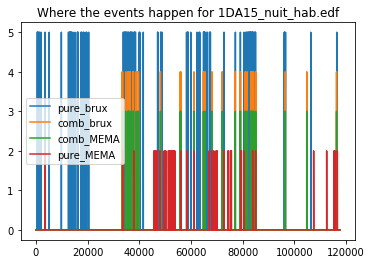

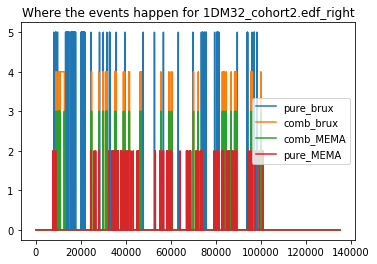

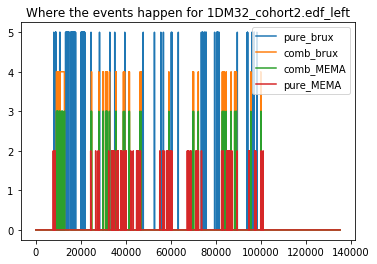

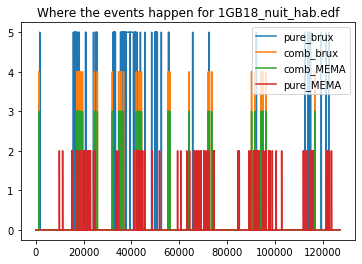

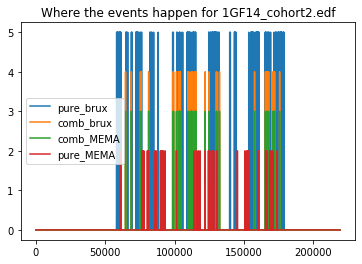

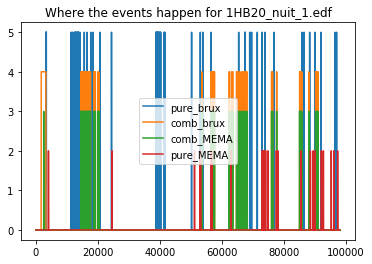

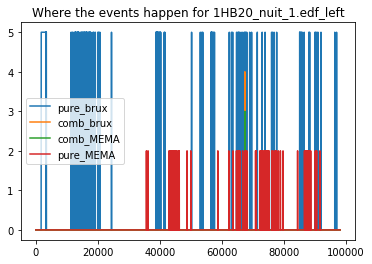

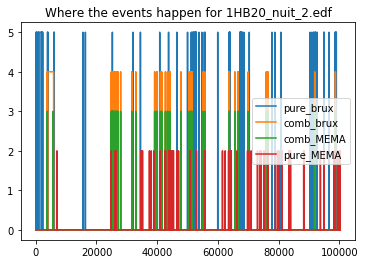

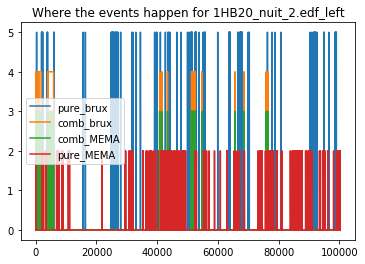

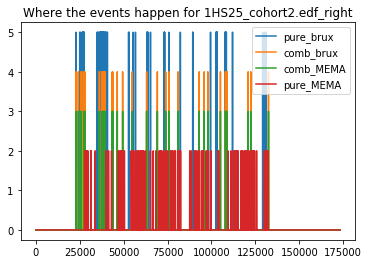

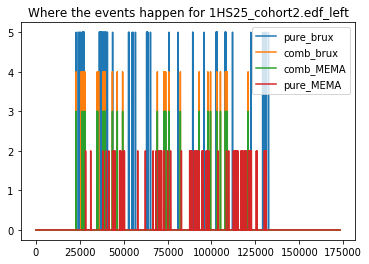

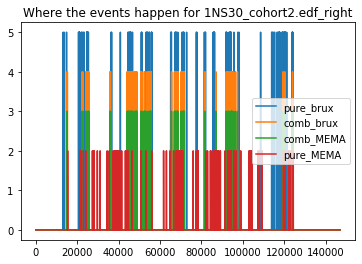

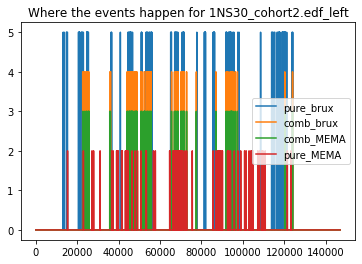

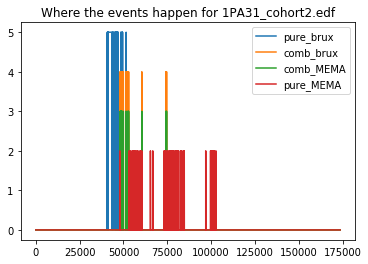

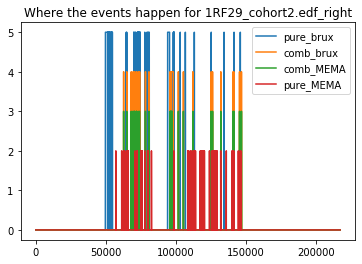

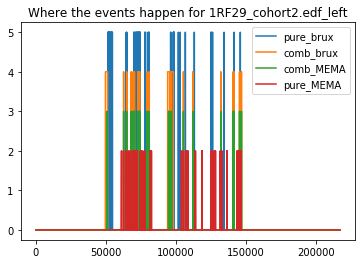

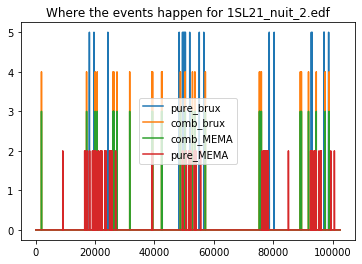

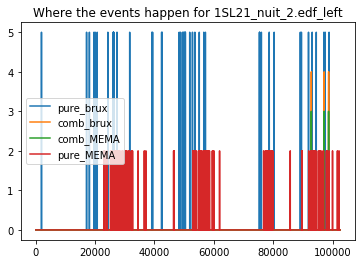

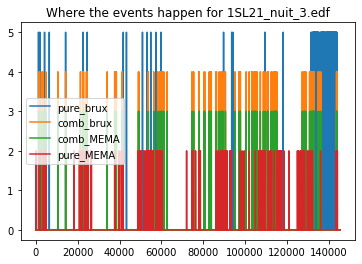

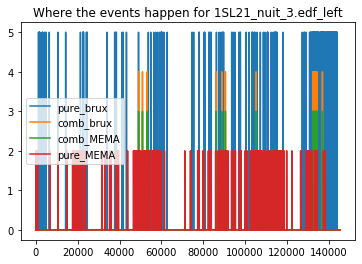

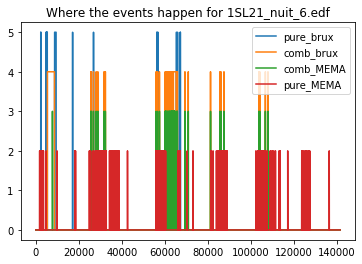

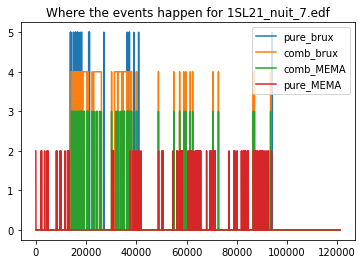

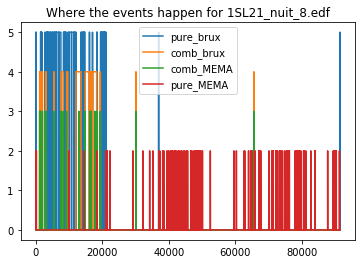

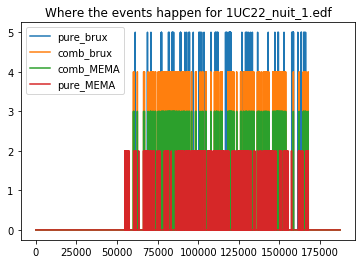

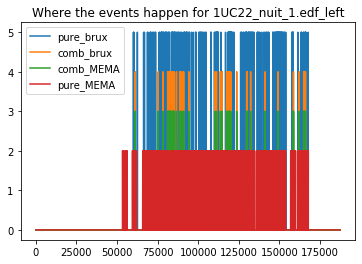

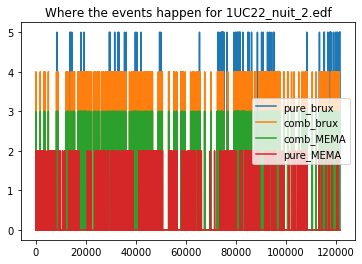

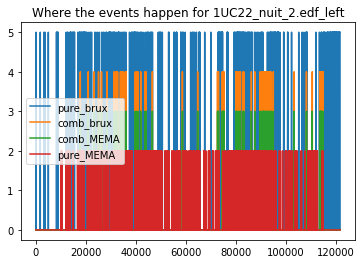

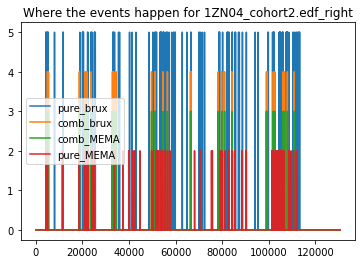

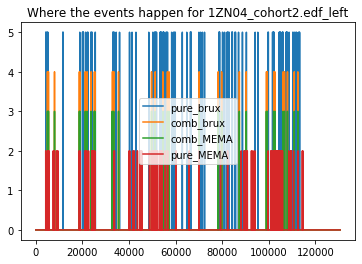

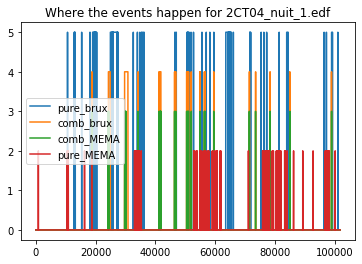

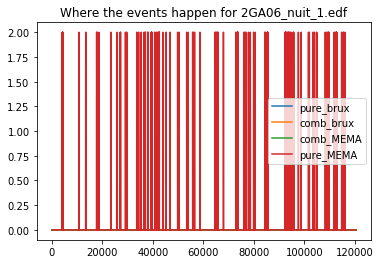

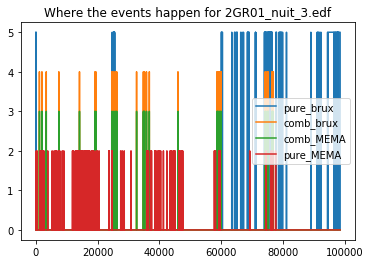

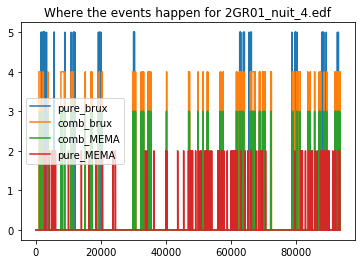

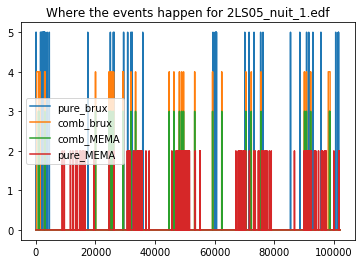

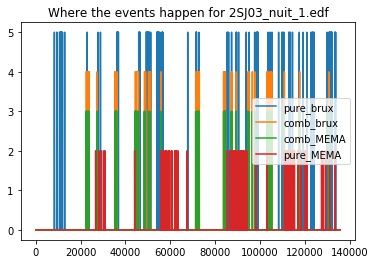

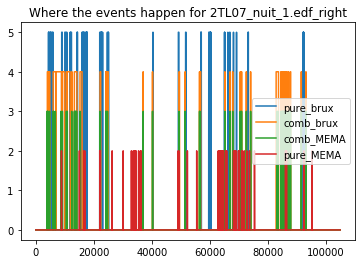

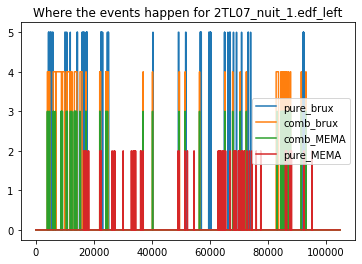

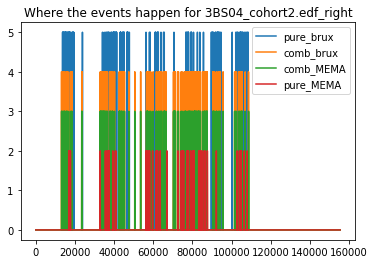

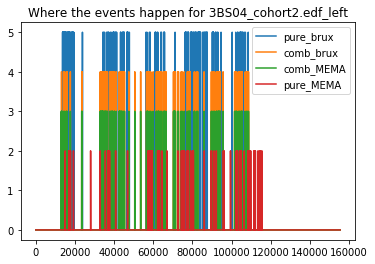

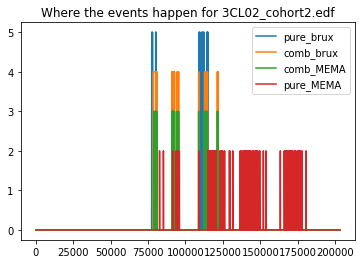

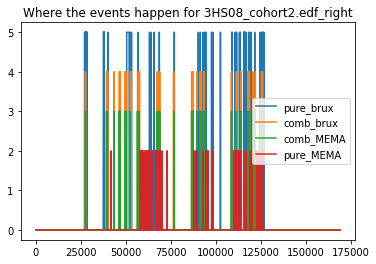

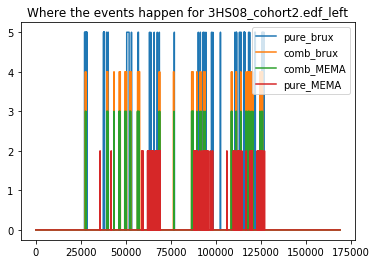

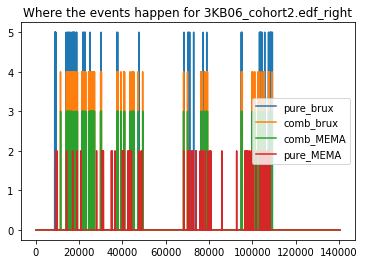

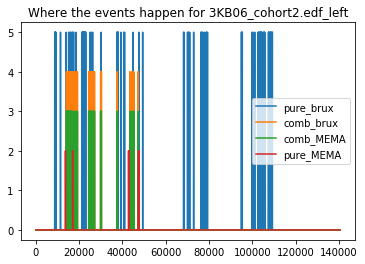

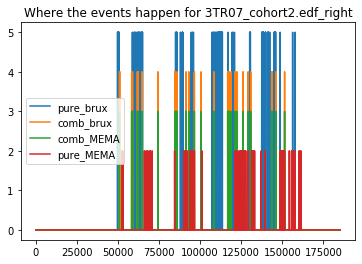

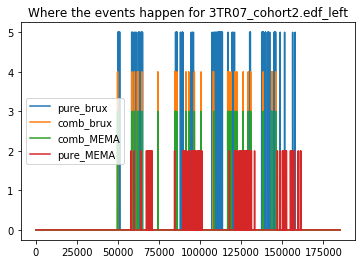

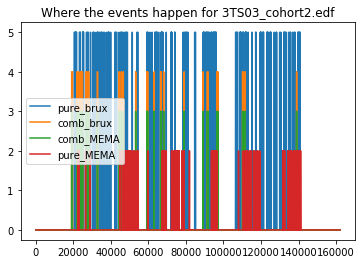

In [8]:
from time import time
# load file from config

ind_THR_brux=0
ind_THR_MEMA = 0

start = time()
results_brux_combine={}
results_brux_pure={}
results_MEMA_combine={}
results_MEMA_pure={}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Files processed : ")
    
    #Loop on all the patient files
    for filename in EDF_list:
        
        #Tester si le fichier has left
        
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        
        
        if (list(results_MEMA.keys()).__contains__(file+"_left")):
            if file ==  "1HB20_nuit_1.edf" or file ==  "1UC22_nuit_1.edf" or file ==  "1SL21_nuit_2.edf"  or file ==  "1HB20_nuit_2.edf" or file ==  "1UC22_nuit_2.edf" or file ==  "1SL21_nuit_3.edf":
                file_sides=[file, file+"_left"]
            else:
               
                    file_sides=[file+"_right", file+"_left"] 
        else:
                file_sides=[file]
            
            
        print(file, end=" ")
        if not (file in results_brux.keys() and file in results_MEMA.keys()):
            #print(results_brux[file]["parameters"]["time_interval"])
            print(f"(does not have both bruxism and mema)... skipping")
        else:
            for file_side in file_sides:
                window_length_brux = results_brux[file]["parameters"]["time_interval"]
                delim_brux = results_brux[file]["parameters"]["delim"]
                window_length_MEMA = results_MEMA[file]["parameters"]["time_interval"]
                delim_MEMA = results_MEMA[file]["parameters"]["delim"]
                params_combine = dict(
                                    labels_brux = results_brux[file]["labels"][ind_THR_brux], 
                                    time_interval_brux = results_brux[file]["parameters"]["time_interval"], 
                                    delim_ep_brux = results_brux[file]["parameters"]["delim"], 
                                    labels_MEMA = results_MEMA[file_side]["labels"][ind_THR_MEMA], #droite ou gauche
                                    time_interval_MEMA = results_MEMA[file]["parameters"]["time_interval"],
                                    delim_ep_MEMA = results_brux[file]["parameters"]["delim"],
                                    min_burst_joining_brux=min_burst_joining_brux, 
                                    min_burst_joining_MEMA=min_burst_joining_MEMA
                                    )
                print(results_MEMA[file_side]["parameters"]["time_interval"])
                print(len(results_brux[file]["labels"][0]))
                print(np.sum(results_brux[file]["labels"][0]))
                print(results_brux[file]["reports"][0])
                print(len(results_MEMA[file_side]["labels"][0])*4)
                print(results_brux[file]["parameters"]["time_interval"])

                brux_comb_ep, brux_pure_ep, MEMA_comb_ep, MEMA_pure_ep = combine_brux_MEMA(**params_combine)
                valid_labels_MEMA= results_MEMA[file_side]["parameters"]["valid_labels"]
                valid_labels_brux= results_brux[file]["parameters"]["valid_labels"]
                #LIGNE IMPORTANTE A CONSERVER
                valid_labels_MEMA = merge_labels_list([valid_labels_MEMA], len(valid_labels_brux))


                results_brux_combine[file_side]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [brux_comb_ep]     ,              
                    "reports": [generate_bruxism_report(brux_comb_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                    }

                results_brux_pure[file_side]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [brux_pure_ep]     ,              
                    "reports": [generate_bruxism_report(brux_pure_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                    }


                results_MEMA_combine[file_side]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [MEMA_comb_ep]     ,              
                    "reports": [generate_MEMA_report(MEMA_comb_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}

                results_MEMA_pure[file_side]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                     "labels": [ MEMA_pure_ep  ]   ,              
                    "reports": [generate_MEMA_report(MEMA_pure_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}

                print("heu")
                print(len(MEMA_comb_ep))
                print(np.sum(brux_comb_ep))
                print(np.sum(brux_pure_ep))
                print(window_length_brux)
                print(delim_brux)
                print(min_burst_joining_brux)

                pure_brux_bursts = classif_to_burst(brux_pure_ep, time_interval=window_length_brux)
                li_ep_brux_p = burst_to_episode(pure_brux_bursts, delim=delim_brux, min_burst_joining= 0)#important!!
                pure_brux_events = episodes_to_list(li_ep_brux_p, window_length_brux, len(brux_pure_ep))

                comb_brux_bursts = classif_to_burst(brux_comb_ep, time_interval=window_length_brux)
                li_ep_brux_c = burst_to_episode(comb_brux_bursts, delim=delim_brux, min_burst_joining= 0) #Important!!
                comb_brux_events = episodes_to_list(li_ep_brux_c, window_length_brux, len(brux_comb_ep))

                comb_MEMA_bursts = classif_to_burst(MEMA_comb_ep, time_interval=window_length_brux) # window_length_brux is valid ?

                pure_MEMA_bursts = classif_to_burst(MEMA_pure_ep, time_interval=window_length_brux) # window_length_brux is valid ?

                print("rapport d'activité : ")
                print("nb episodes bruxisme combinés : ")
                print(len(li_ep_brux_c))
                print("Nb épisodes bruxisme purs : ")
                print(len(li_ep_brux_p))
                print("nb episodes MEMA combinés : ")
                print(len(comb_MEMA_bursts))
                print("Nb épisodes MEMA purs : ")
                print(len(pure_MEMA_bursts))


                print("rapport d'activité taux horaire : ")
                print("nb episodes bruxisme combinés : ")
                print(len(li_ep_brux_c)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("Nb épisodes bruxisme purs : ")
                print(len(li_ep_brux_p)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("nb episodes MEMA combinés : ")
                print(len(comb_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("Nb épisodes MEMA purs : ")
                print(len(pure_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))

                new_l_comb=[]
                for i in range(len(MEMA_comb_ep)):
                    if MEMA_comb_ep[i]:
                        new_l_comb.append(3)
                    else:
                        new_l_comb.append(0)

                new_l_pure=[]
                for i in range(len(MEMA_pure_ep)):
                    if MEMA_pure_ep[i]:
                        new_l_pure.append(2)
                    else:
                        new_l_pure.append(0)

                for i in range(len(comb_brux_events)):
                    if comb_brux_events[i]>0:
                        comb_brux_events[i]=4

                for i in range(len(pure_brux_events)):
                    if pure_brux_events[i]>0:
                        pure_brux_events[i]=5

                plt.figure()
                plt.plot(pure_brux_events, label="pure_brux")
                plt.plot(comb_brux_events, label="comb_brux")
                plt.plot(new_l_comb, label="comb_MEMA")
                plt.plot(new_l_pure, label="pure_MEMA")
                plt.legend()
                plt.title("Where the events happen for " + file_side)


pd.DataFrame.from_dict(results_brux_combine).to_pickle("data/reports_and_datas_bruxism_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_brux_pure).to_pickle("data/reports_and_datas_bruxism_pure.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_combine).to_pickle("data/reports_and_datas_MEMA_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_pure).to_pickle("data/reports_and_datas_MEMA_pure.pk", protocol=3)
print("results saved!!")

## Display of the last computed recording

In [15]:
raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
duration_brux = int(results_brux[file]["parameters"]["time_interval"] * raw.info['sfreq'])  
interval_brux=duration_brux
print(duration_brux)

#print(new_l_comb)

#print(len(raw))
#-----------------Pure MEMA episodes visualisation and comparison with ATM activity -----------------------------------
#Preparing raw for visualisation
picks_chan = ['Mask Pressure', '1', '2', "Activity"]           # subset of EMG electrodes

print(raw.info["sfreq"])

raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=['misc','emg','emg', "misc"])        # pick channels and load
print(len(raw))
scalings = dict(misc=1, emg=1e-5)

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['1', '2'])
#Annotating the raw
raw = CleanAnnotations(raw)
dict_annotations = {1: "b_pure", 2:"M_pure", 3:"M_comb", 4:"b_comb"}
#raw = AnnotateRaw_sliding(raw, results_brux[file]["labels"][ind_THR_brux][1:-1] , 
#                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_pure[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)

raw = AnnotateRaw_sliding(raw,  pure_brux_events[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, comb_brux_events[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_comb[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)


print("Raw annotated")
scalings = {'emg': 5e-5, 'misc': 0.2, 'bio':1e3}
raw.plot(scalings = scalings)
plt.title(filename)

<ipython-input-15-19e6e5c6232f>:1: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading


62
250.0
8710000
Raw annotated


Text(0.5, 1, 'F:/Acou_sommeil/EDF_renom\\3KB06_cohort2.edf')

## Analysis 

In [63]:
#Here replace with the metric to analyse
info_file = "data/data_info.csv"
print(os.getcwd())
results_file = "data/reports_and_datas_MEMA_pure.pk"
results = pd.read_pickle(results_file).to_dict()
THR_classif = results[list(results.keys())[0]]["THR_classif"]

THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & session == "1" & emg==1 ')
#data_info = pd.read_csv(info_file, sep=",").query('mema == 1 & included == 1 & emg==1 ')
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema pure {data_info.shape[0]}")
print(data_info[["filename", "condition"]])
results_updated = dict()
for filename in results.keys():
    if filename in data_info["filename"].values:
        if not filename == "3CL02_cohort2.edf":
            if not filename == "1CB23_cohort2.edf":
                #if not filename == "3TS03_cohort2.edf":
                    if not filename == "2GA06_nuit_1.edf":
                       if not filename == "1GF14_cohort2.edf":
                            results_updated[filename] = results[filename]
results = results_updated
print(len(results_updated.keys()))

C:\Users\Zeta\Documents\acou_sommeil_HD_ENS\Tinnitus-n-Sleep\notebooks
Valid files for mema pure 24
              filename    condition
4   1DA15_nuit_hab.edf  habituation
9   1GB18_nuit_hab.edf  habituation
28    1HB20_nuit_1.edf  habituation
36    1SL21_nuit_2.edf  habituation
40    1UC22_nuit_1.edf  habituation
42    2GA06_nuit_1.edf      control
43    2SJ03_nuit_1.edf      control
49    2LS05_nuit_1.edf      control
50    2CT04_nuit_1.edf      control
57   1ZN04_cohort2.edf       batch2
58   1HS25_cohort2.edf       batch2
59   1PA31_cohort2.edf       batch2
60   3NS01_cohort2.edf       batch2
62   1RF29_cohort2.edf       batch2
63   1GF14_cohort2.edf       batch2
64   1DM32_cohort2.edf       batch2
65   3BS04_cohort2.edf       batch2
66   3TR07_cohort2.edf       batch2
67   3KB06_cohort2.edf       batch2
68   1NS30_cohort2.edf       batch2
69   1AC26_cohort2.edf       batch2
71   3TS03_cohort2.edf       batch2
72   3HS08_cohort2.edf       batch2
73    2TL07_nuit_1.edf      control


In [64]:
get_scores=[]
for elm in results.keys():
        print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            print(ep["Number of MEMA episodes per hour"])
            
            l_ep_h.append(ep["Number of MEMA episodes per hour"])
        print(ep.keys())

        get_scores.append([elm.split(os.path.sep)[-1], l_ep_h])
print(len(get_scores))
print(get_scores)

1AC26_cohort2.edf
9.501177728404135
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1DA15_nuit_hab.edf
6.116207951070336
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1DM32_cohort2.edf
9.883687618174525
dict_keys(['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode'])
1GB18_nuit_hab.edf
17.202137692549513
dict_keys(['Clean MEMA duration', 'Total MEMA burst 

In [65]:
# format reports
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
#putting away damaged recordings
data_info["category"] = data_info["mask_per"].apply(map_category)



reports = reports.merge(data_info, on="filename")

In [66]:
##Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

Nb_patients in each group : 
Tinnitus stable : 6, ['1DA15', '1GB18', '1SL21', '1PA31', '1RF29', '3KB06']
Tinnitus decrease : 6, ['1HB20', '1ZN04', '3NS01', '3BS04', '3TR07', '3HS08']
Tinnitus increase : 7, ['1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26', '3TS03']
Tinnitus control : 5, ['2GA06', '2SJ03', '2LS05', '2CT04', '2TL07']


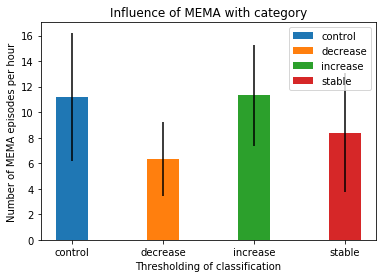

In [67]:
#Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
width = 0.35
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.bar(category, report_mean.loc[category][value], width, yerr = report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

In [68]:
l=[]
for i in range(4):
    print(list(reports.groupby(['category', 'THR_classif']))[i][0])
    print(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
    l.append(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
print(scipy.stats.ttest_ind(l[0], l[2]))
print(scipy.stats.ttest_ind(l[1], l[2]))
print(scipy.stats.ttest_ind(l[3], l[2]))

('control', 3)
[11.2636446936352, 18.21346177196746, 8.551223252486269, 6.779617242180841]
('decrease', 3)
[3.8172920065252853, 11.32996511654313, 5.321709254172303, 5.836941046132435, 5.2526498442497855]
('increase', 3)
[9.501177728404135, 9.883687618174525, 10.304990482545374, 10.074334984148836, 19.367647180346022, 8.861340606461797]
('stable', 3)
[6.116207951070336, 17.202137692549513, 5.353171791461245, 4.478306282283909, 9.481191705608211, 7.749926519215225]
Ttest_indResult(statistic=-0.04590027376009484, pvalue=0.9645148353572424)
Ttest_indResult(statistic=-2.3451290065463772, pvalue=0.04365200900207299)
Ttest_indResult(statistic=-1.173493825739411, pvalue=0.2677899850700038)


In [69]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys()) #(remove power ratio a sleep analysis)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode']


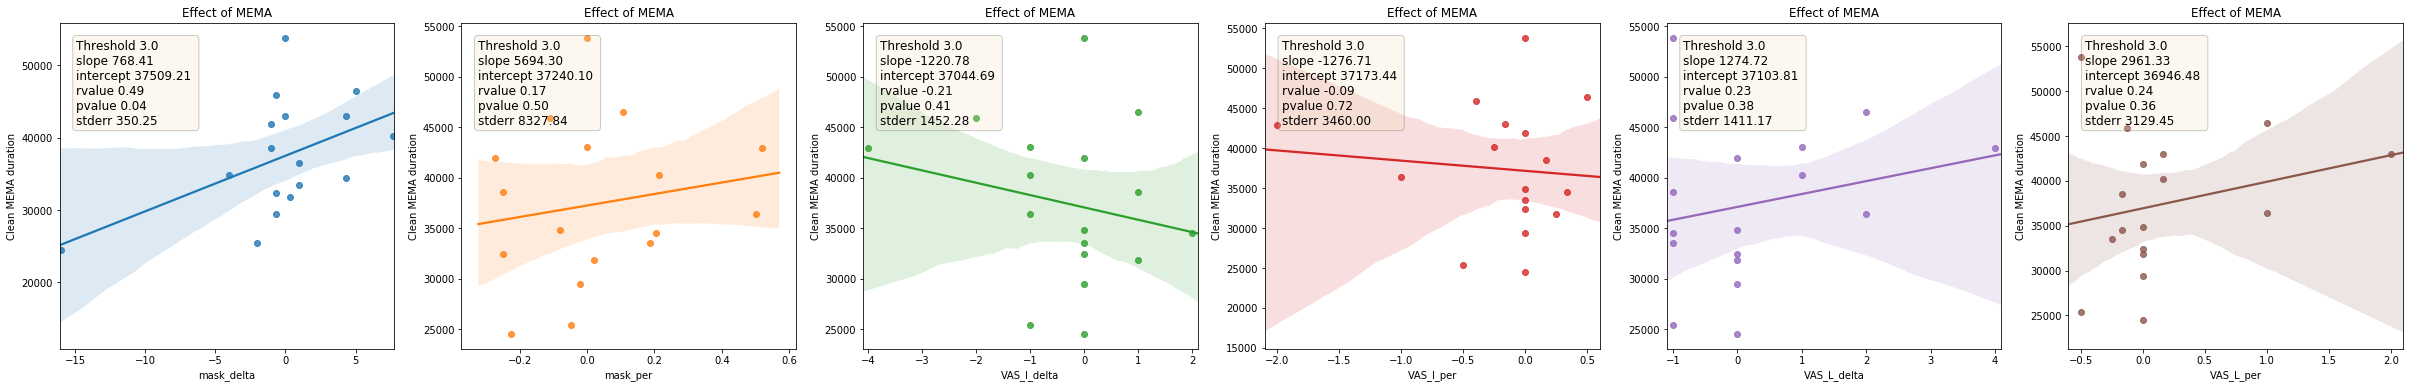

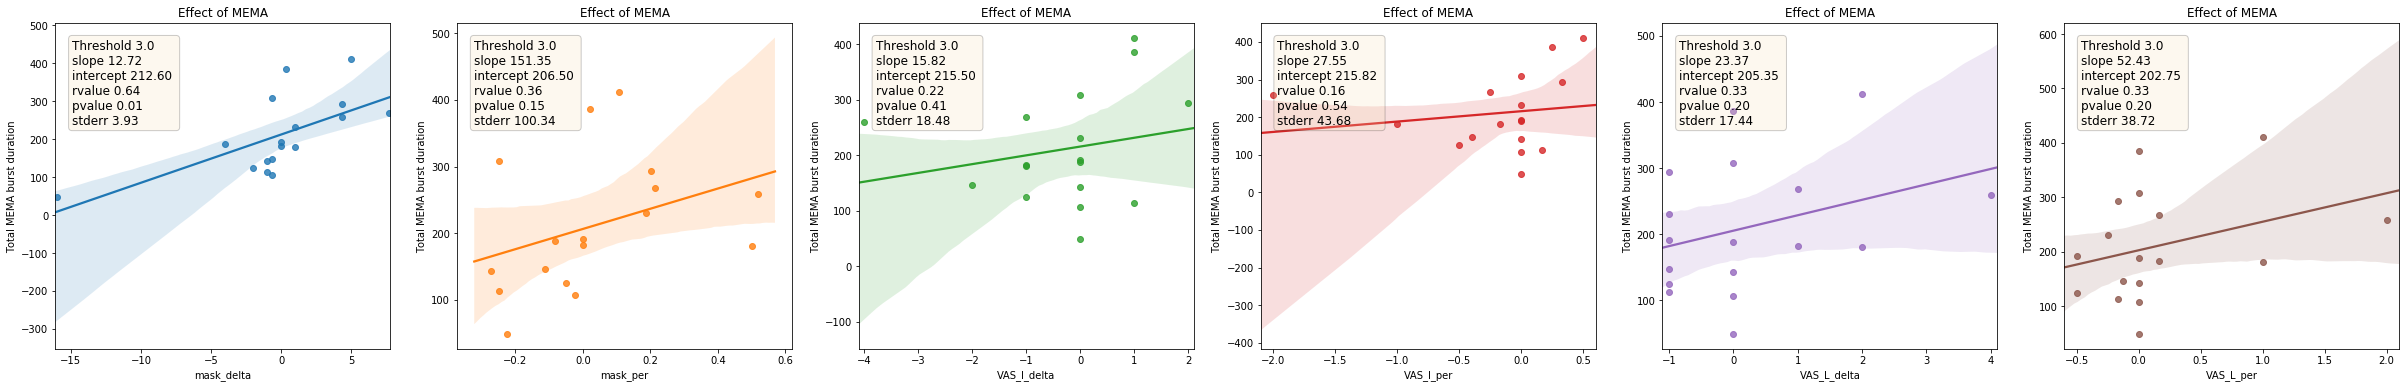

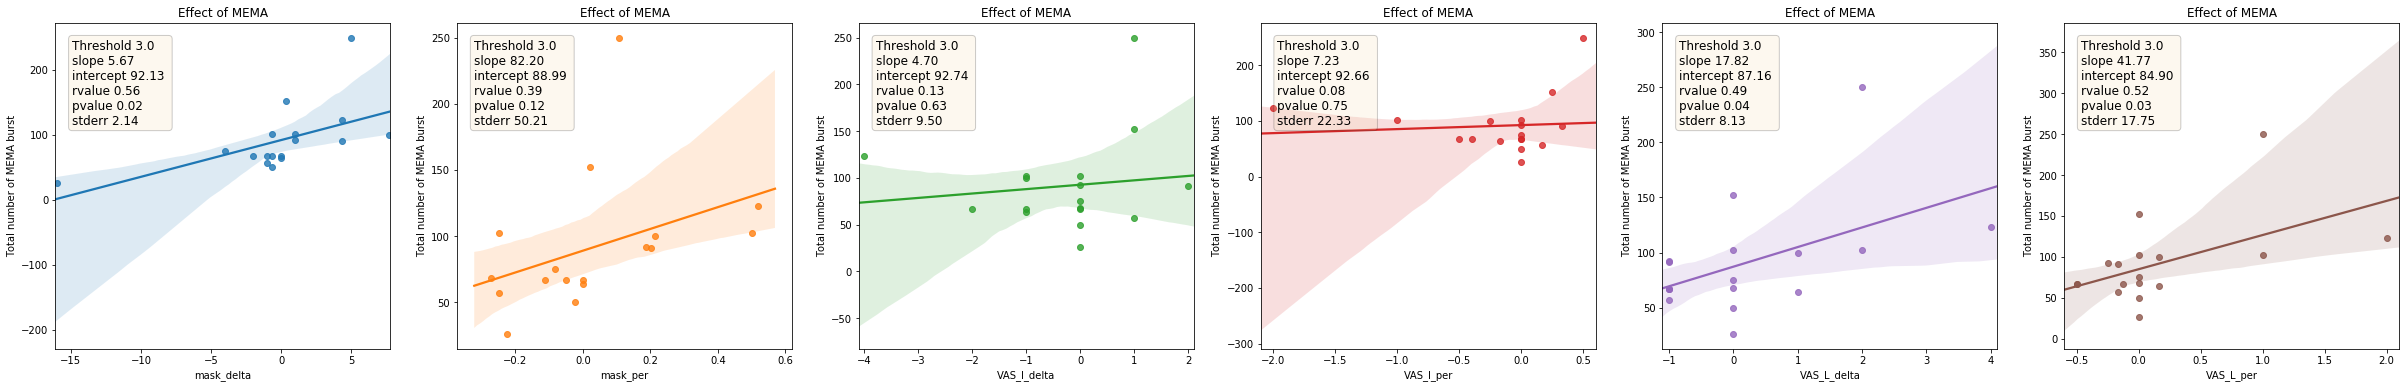

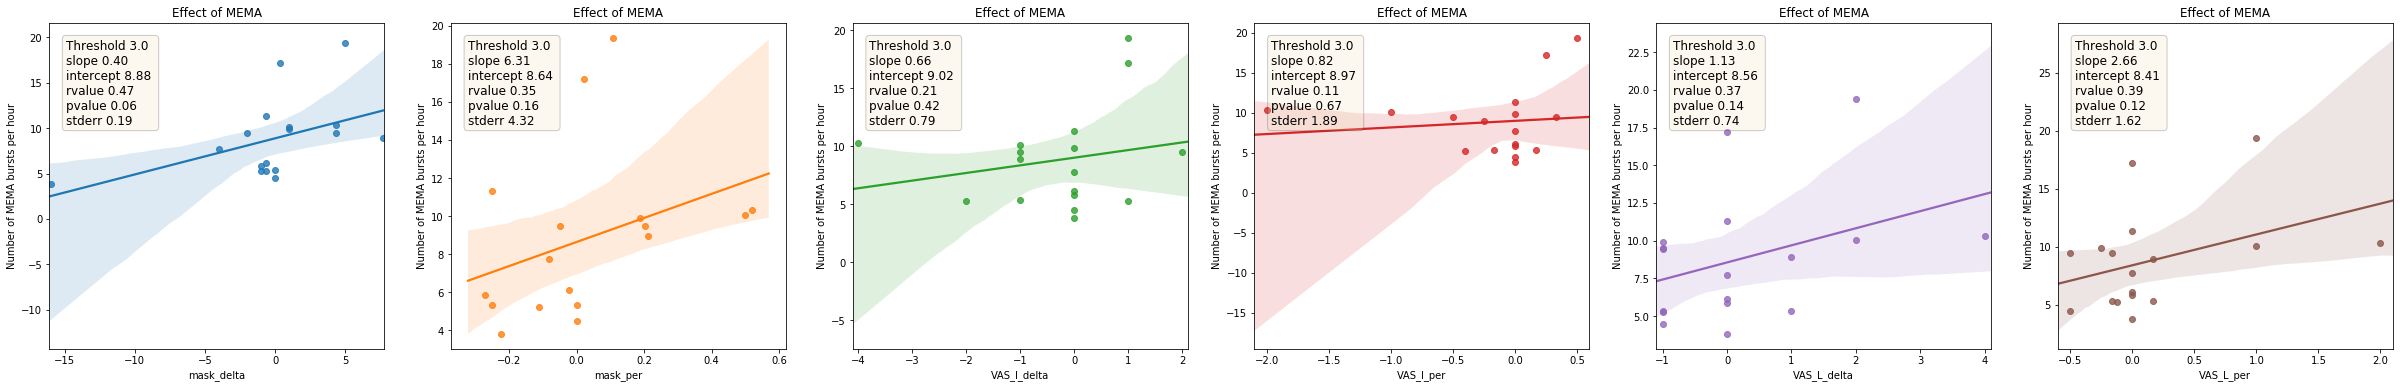

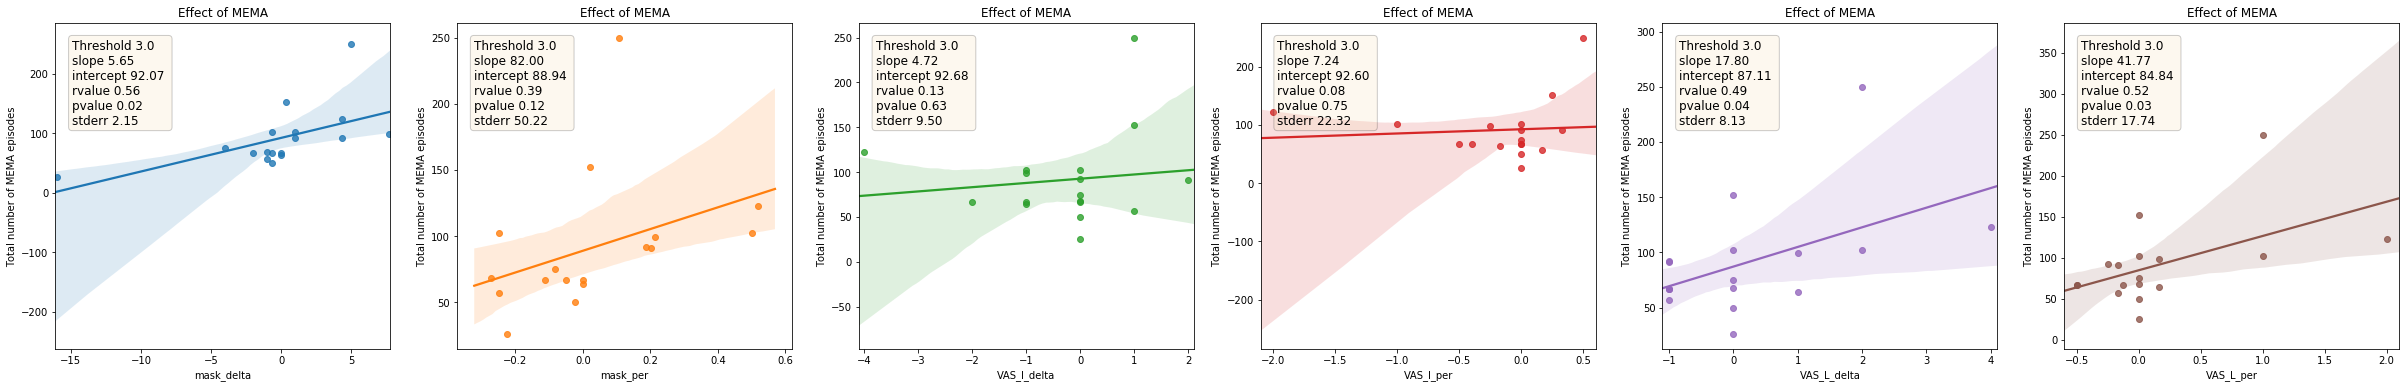

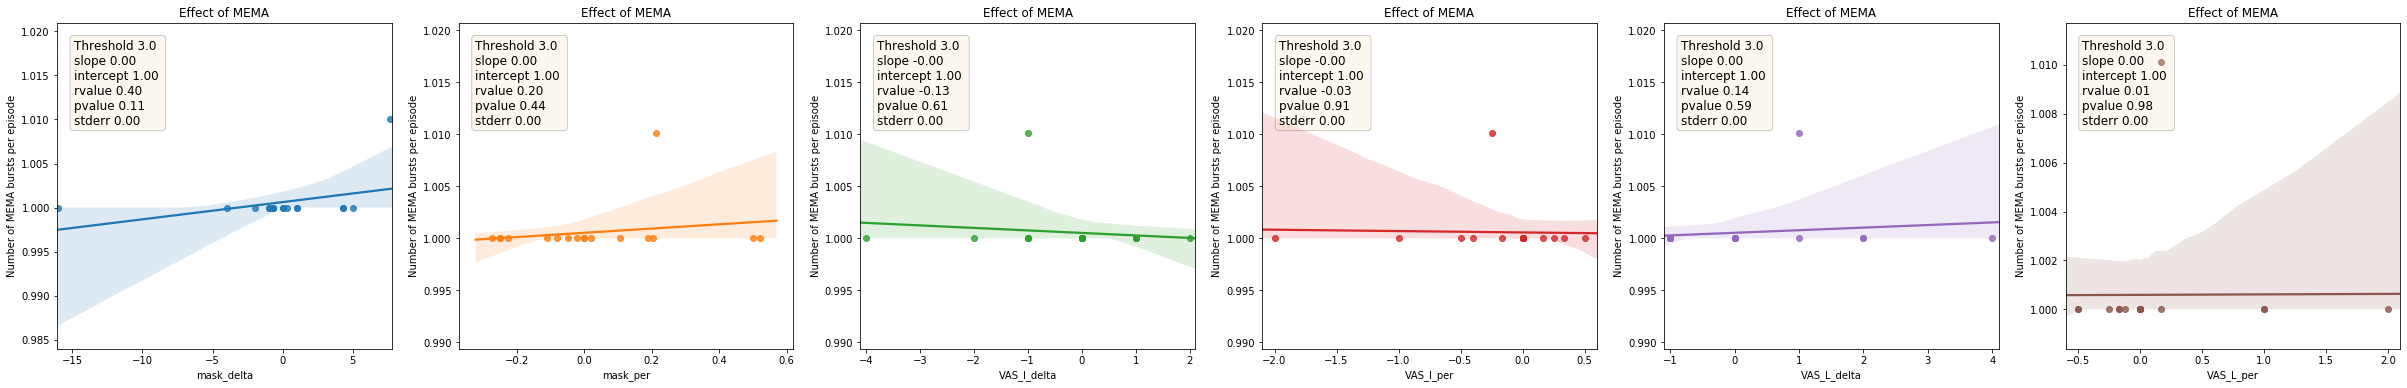

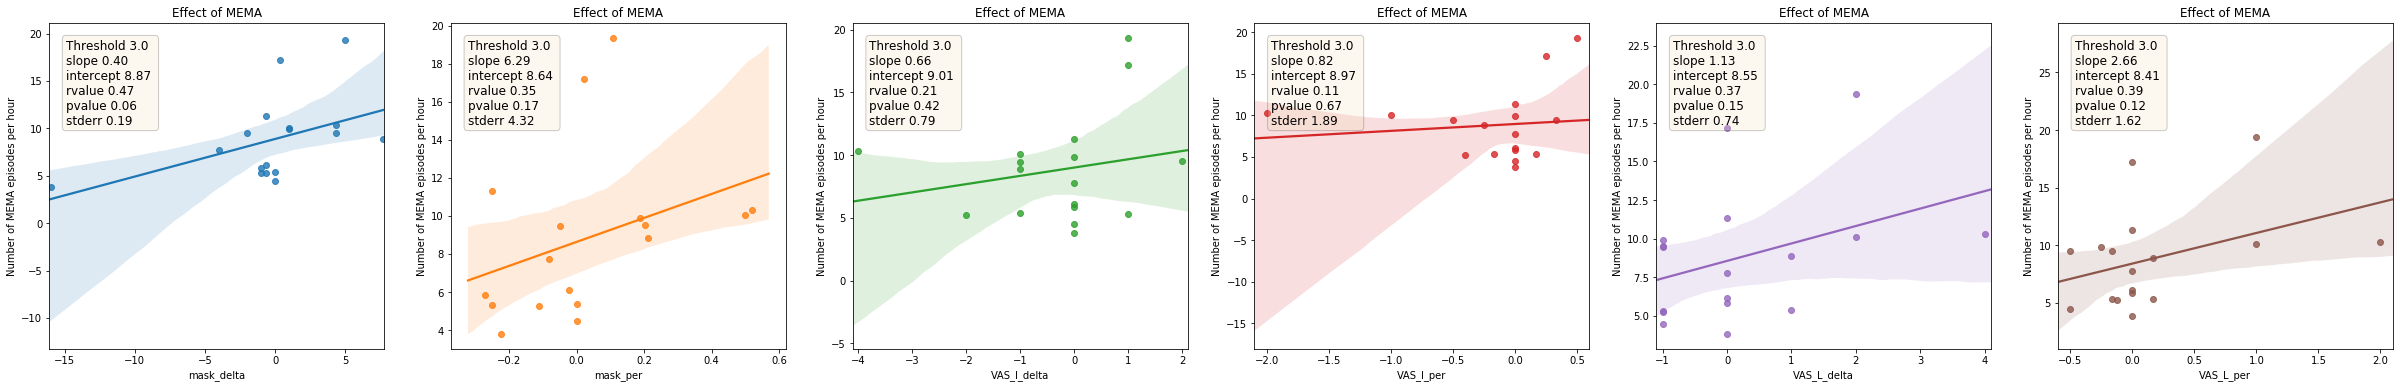

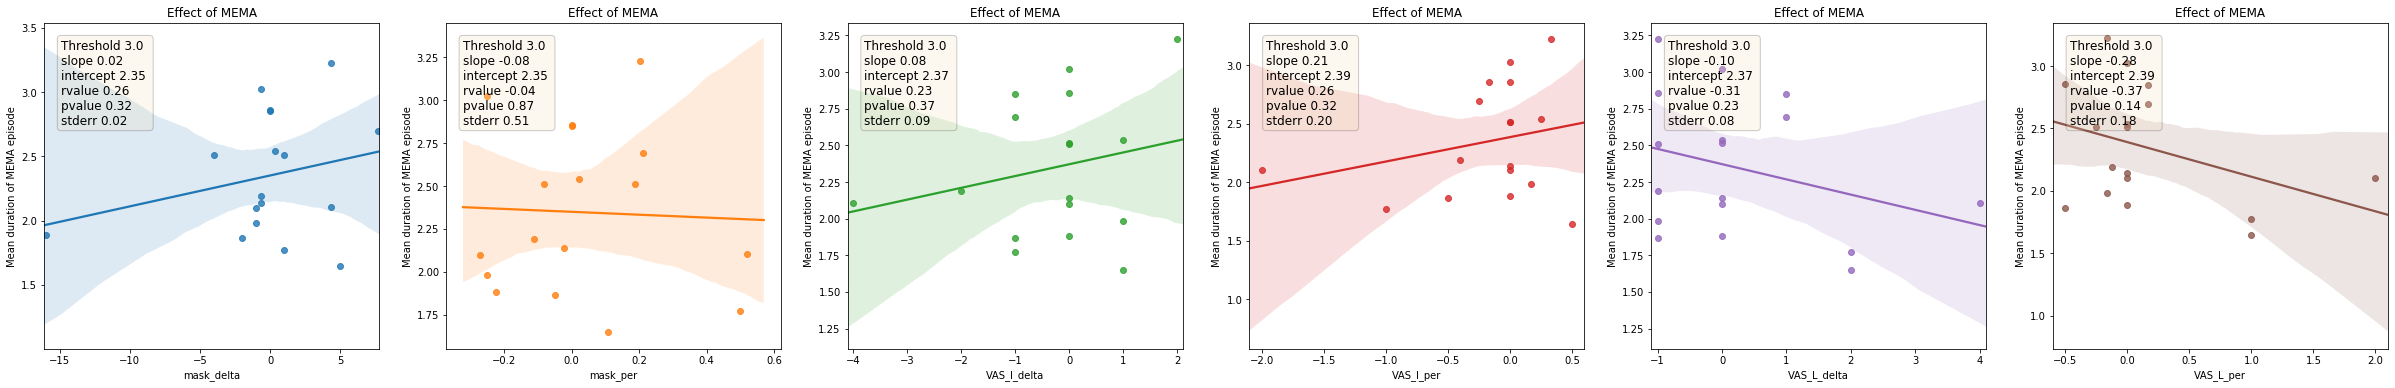

In [70]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            regression_result = scipy.stats.linregress(data_loc[x_axis].values,data_loc[y_axis].values)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [71]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,slope,intercept,rvalue,pvalue,stderr
0,mask_delta,Clean MEMA duration,3,768.414857,37509.214588,0.492875,0.044411,350.253519
0,mask_delta,Total MEMA burst duration,3,12.721352,212.596892,0.640826,0.005574,3.934880
0,mask_delta,Total number of MEMA burst,3,5.667240,92.130798,0.563886,0.018394,2.143074
0,VAS_L_delta,Total number of MEMA burst,3,17.823864,87.159091,0.492668,0.044514,8.128868
0,VAS_L_per,Total number of MEMA burst,3,41.771826,84.902880,0.519347,0.032640,17.746965
0,mask_delta,Total number of MEMA episodes,3,5.647850,92.069313,0.562070,0.018858,2.145853
0,VAS_L_delta,Total number of MEMA episodes,3,17.799242,87.106061,0.492086,0.044805,8.130305
0,VAS_L_per,Total number of MEMA episodes,3,41.769876,84.844357,0.519428,0.032608,17.742382


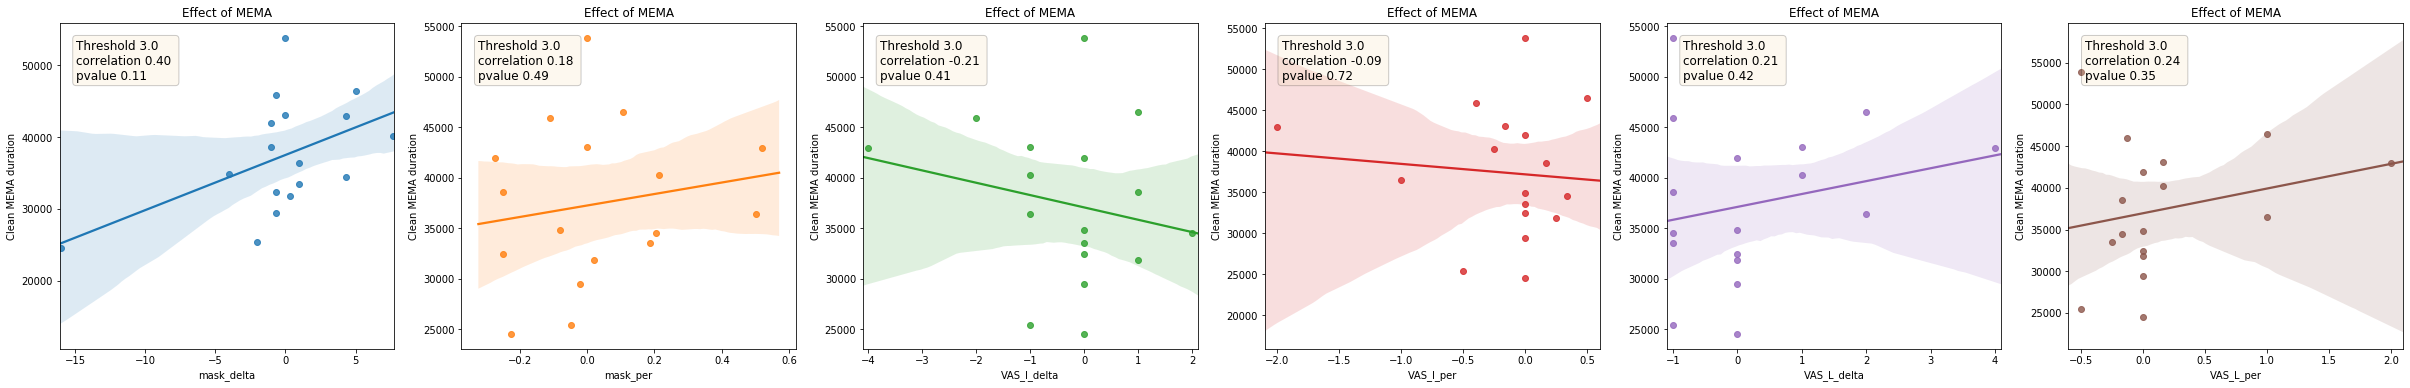

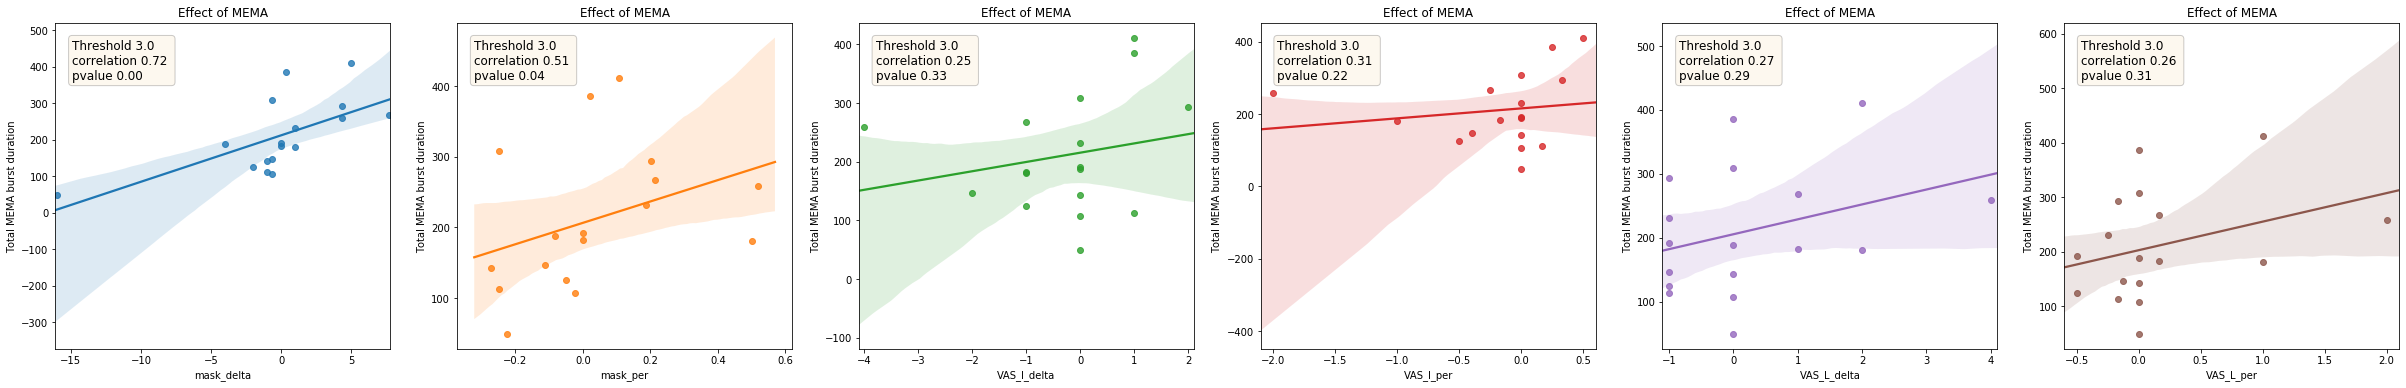

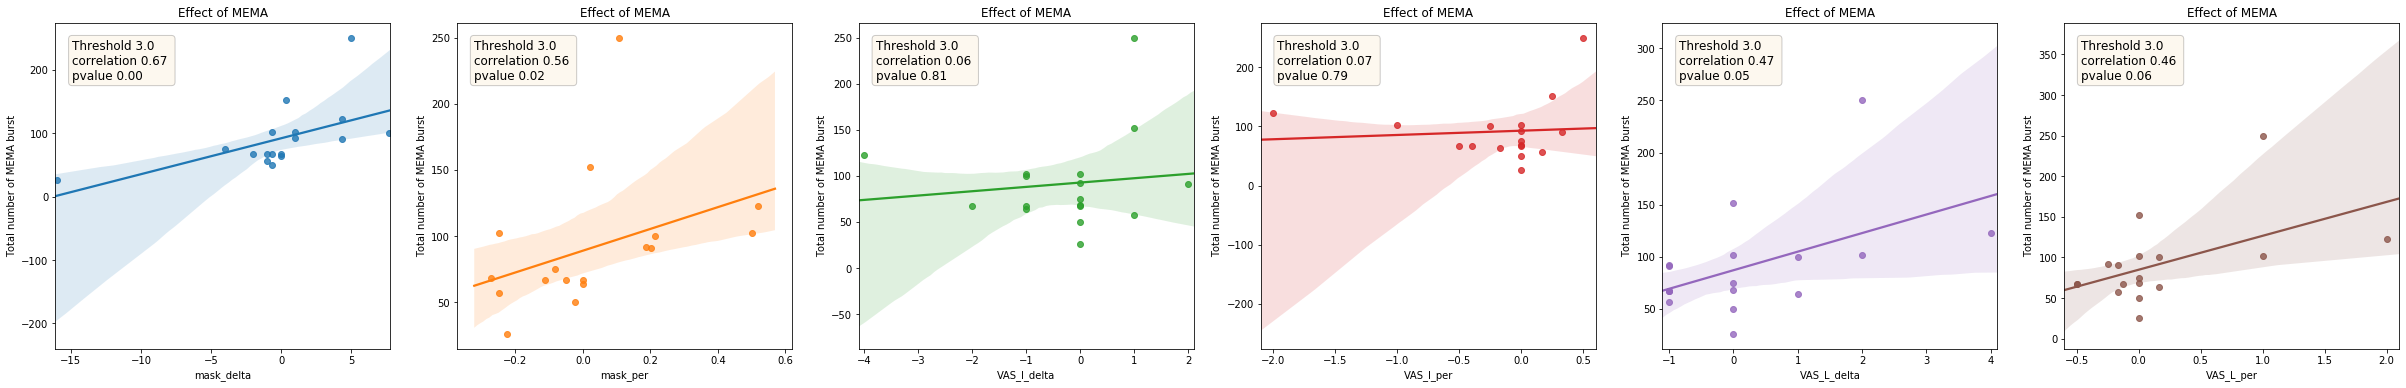

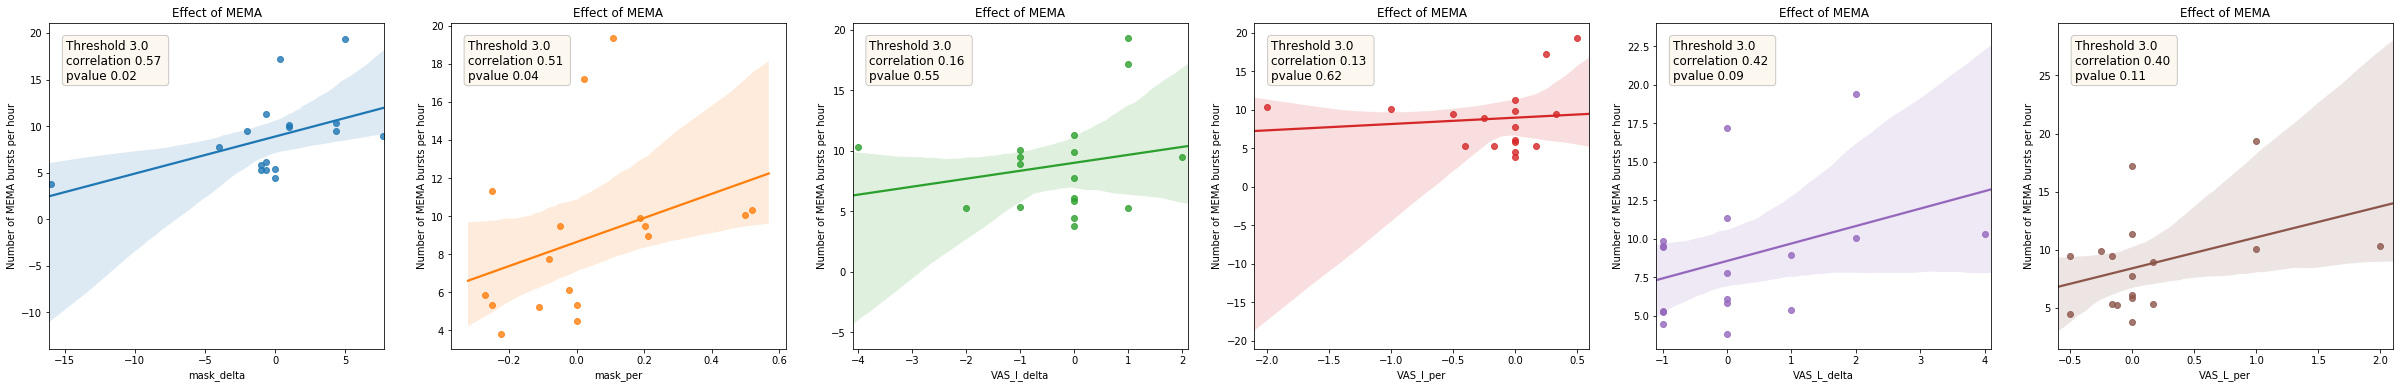

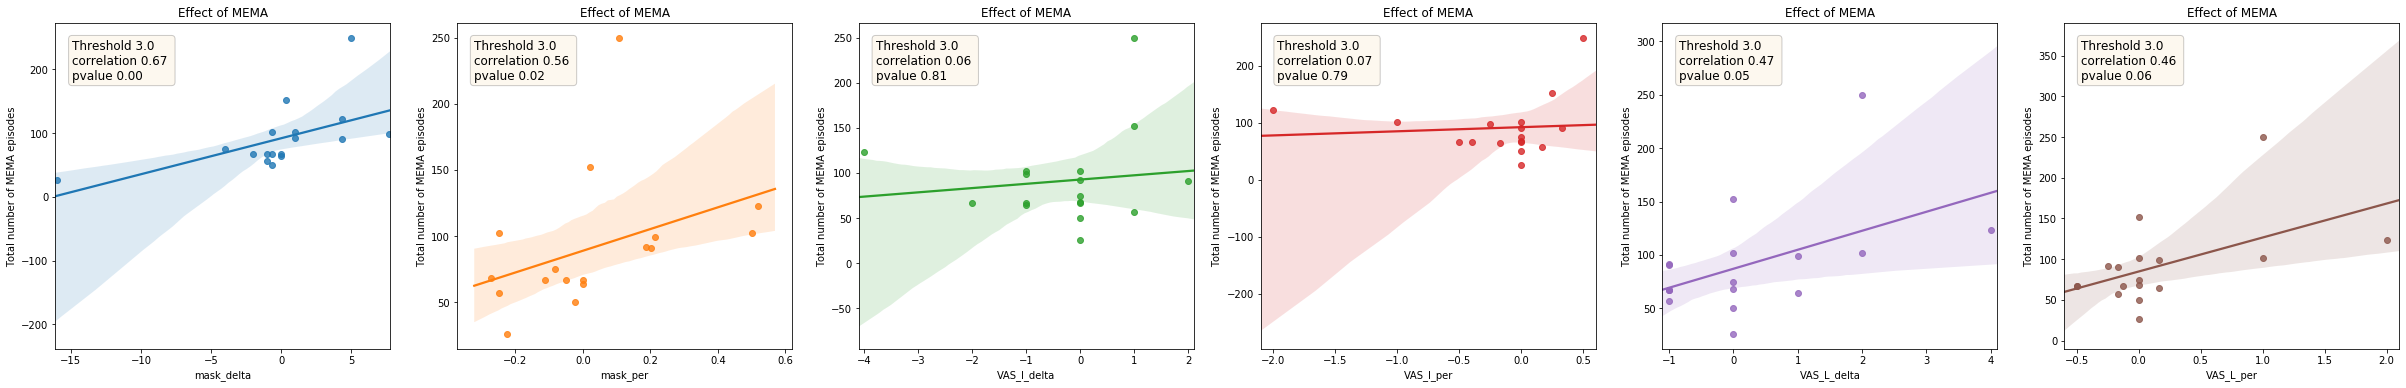

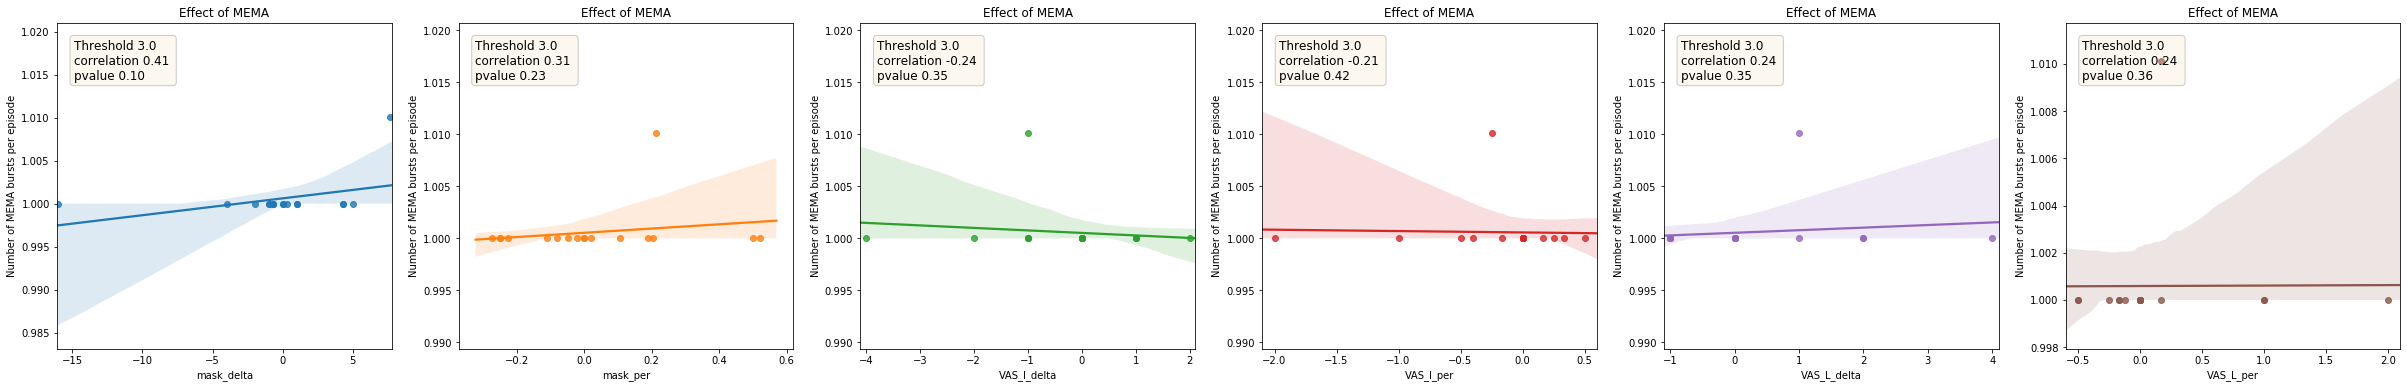

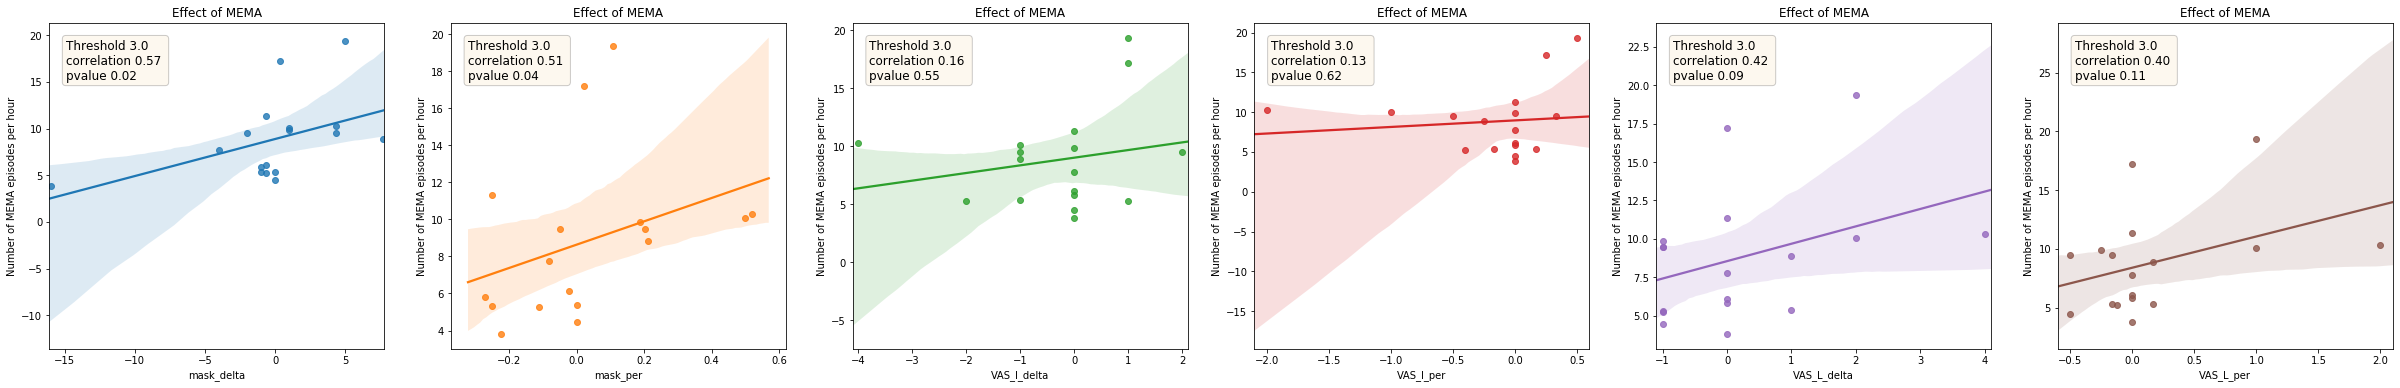

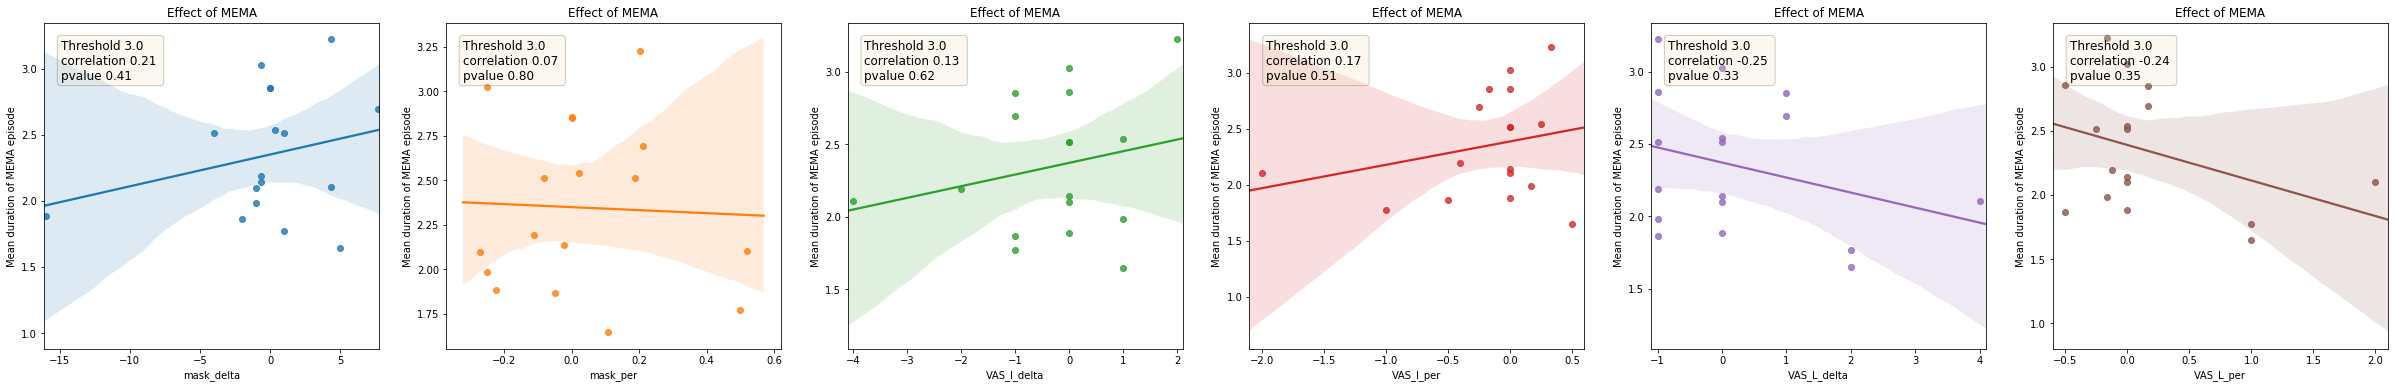

In [60]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            regression_result = scipy.stats.spearmanr(data_loc[x_axis].values,data_loc[y_axis].values)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [61]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,correlation,pvalue
0,mask_delta,Total MEMA burst duration,3,0.723699,0.001023
0,mask_per,Total MEMA burst duration,3,0.505522,0.038444
0,mask_delta,Total number of MEMA burst,3,0.674692,0.002968
0,mask_per,Total number of MEMA burst,3,0.559386,0.019559
0,mask_delta,Number of MEMA bursts per hour,3,0.568621,0.017228
0,mask_per,Number of MEMA bursts per hour,3,0.507976,0.037360
0,mask_delta,Total number of MEMA episodes,3,0.674692,0.002968
0,mask_per,Total number of MEMA episodes,3,0.559386,0.019559
0,mask_delta,Number of MEMA episodes per hour,3,0.568621,0.017228
0,mask_per,Number of MEMA episodes per hour,3,0.507976,0.037360
